In [1]:
import pdfplumber
import pandas as pd
import itertools
import numpy as np

In [2]:
pdf = pdfplumber.open("./balder_arsredovisning_2020.pdf")

In [3]:
pdf

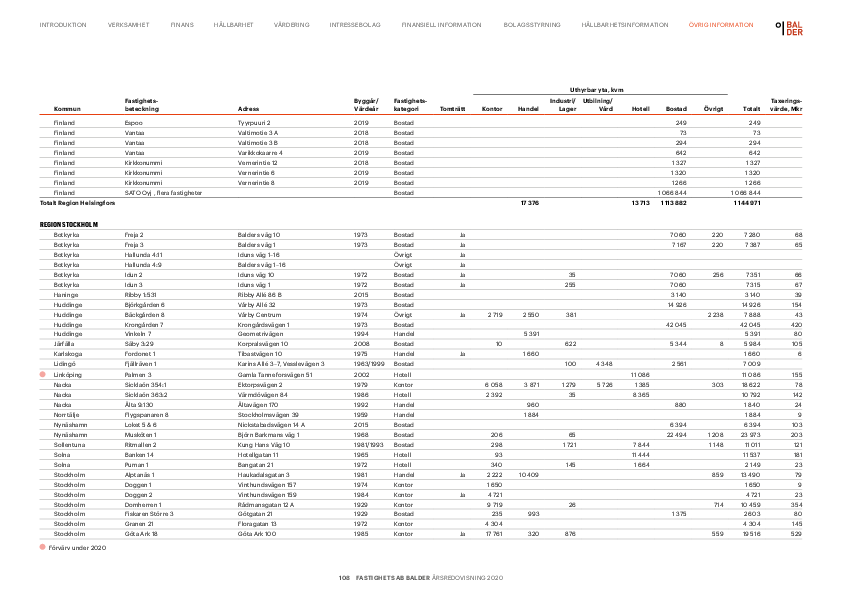

In [4]:
page_numbers = range(106, 120 + 1)#123 + 1

page = pdf.pages[page_numbers[2]]

im = page.to_image()

im

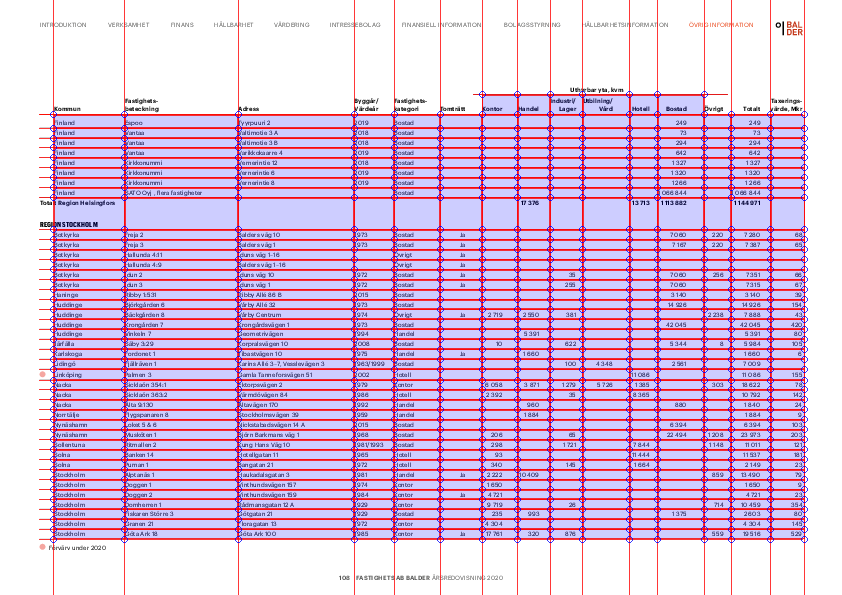

In [5]:
vertical_lines = [
 53.852,
 124.718,
 #159.809,
 238.106,
 #276.255,
 354.326,
 394.01,
 482.027,
 440.027, #tomträtt
 517.715,
 549.965,
 582.503,
 631.715-2,
 665.657-8,
 704.333,
 743.183-12,
 770.783,
 804.783,
]

#SATO Oyj , flera fastigheter is wrong

table_settings = {
    "vertical_strategy": "explicit", 
    "horizontal_strategy": "lines",
    "explicit_vertical_lines": vertical_lines,
    "explicit_horizontal_lines": [],
    "snap_tolerance": 3,
    "join_tolerance": 3,
    "edge_min_length": 3,
    "min_words_vertical": 3,
    "min_words_horizontal": 1,
    "keep_blank_chars": False,
    "text_tolerance": 3,
    #"text_x_tolerance": None,
    #"text_y_tolerance": None,
    "intersection_tolerance": 3,
    #"intersection_x_tolerance": None,
    #"intersection_y_tolerance": None,
}

im.reset().debug_tablefinder(table_settings)

In [6]:
set([float(x[0]) for x in page.find_tables(table_settings)[0].cells])

page.find_tables(table_settings)[0].bbox

(Decimal('53.852'), Decimal('94.838'), Decimal('804.783'), Decimal('539.253'))

In [7]:
tables = page.extract_tables(table_settings)

print(len(tables))

#pd.DataFrame(tables[0])

1


In [8]:
raw_tables = []

for page_number in page_numbers:
    p = pdf.pages[page_number]
    
    tables = p.extract_tables(table_settings)
    print(page_number, len(tables))
    
    assert len(tables) == 1

    #pd.DataFrame(tables[0])
    
    raw_tables.append(tables[0])

106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1


In [9]:
first_line = [None,
  None,
  None,
  None,
  None,
  None,
  'Kontor',
  'Handel',
  'Industri/ \nLager',
  'Utbilning/ \nVård',
  'Hotell',
  'Bostad',
  None,
  None,
  None]

def parse_table(raw_table):
    table = []
    
    assert raw_table[0] == first_line
    
    rows = []
    
    for raw_row in raw_table[1:]:
        row = raw_row#[1:-1]
        
        if set(row) == {''}: # empty row
            continue
            
        if row[0].startswith('t Region '):
            continue
            
        if row[0].startswith('ON ') and set(row[1:]) == {''}:
            continue
        
        #print(row)
        
        rows.append(row)
    
    return rows

#pd.DataFrame(parse_table(raw_tables[7]))

rows = list(itertools.chain.from_iterable([parse_table(raw_table) for raw_table in raw_tables]))

column_names = ["Kommun",
"Fastighetsbeteckning",
"Adress",
"Byggår/Värdeår",
"Fastighetskategori",
"Tomträtt",
"Kontor",
"Handel",
"Industri/Lager",
"Utbilning/Vård",
"Hotell",
"Bostad",
"Övrigt",
"Totalt",
"Taxeringsvärde, Mkr"]

rows

df = pd.DataFrame(rows, columns=column_names)

number_keys = column_names[column_names.index("Kontor"):column_names.index("Taxeringsvärde, Mkr") + 1]

df[number_keys] = df[number_keys].replace(' ', '', regex=True).replace('^$', np.nan, regex=True).astype('float').astype('Int64')

pd.set_option("display.max_rows", None, "display.max_columns", None)

#df

In [10]:
df.loc[df[number_keys[:-2]].sum(axis=1) != df['Totalt']]

,Kommun,Fastighetsbeteckning,Adress,Byggår/Värdeår,Fastighetskategori,Tomträtt,Kontor,Handel,Industri/Lager,Utbilning/Vård,Hotell,Bostad,Övrigt,Totalt,"Taxeringsvärde, Mkr"
532,Karlstad,Braxen 34,Nygatan 1,1944,Bostad,,<NA>,322,27,<NA>,<NA>,1198,521,2067,23
564,Sundsvall,Nolby 41:3 & 37:1,Affärsgatan 14,1974,Bostad,,<NA>,1006,5,<NA>,<NA>,5328,43,6381,21


In [11]:
df.to_excel('./data.xlsx', index=False)
df.to_csv('./data.csv', index=False)